<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [2]:
proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
proverbs.shape

(134493, 4)

In [3]:
proverbs.sample(3)

,text,place,uri,collector
108757,Τον πιάσανε οι Πολλωνιάτες,Μήλος,http://hdl.handle.net/20.500.11853/262937,"Σπυριδάκης, Γεώργιος Κ."
114310,"Μάρτη, Μάρτη ορθοχέστη και παλουκοκαύτη",Μακεδονία,http://hdl.handle.net/20.500.11853/278365,"Τσικόπουλος, Ι."
76797,Εσκορπίσανε σαν του λαγού τα παιδιά,Κεφαλληνία,http://hdl.handle.net/20.500.11853/275288,"Μαρινάτος, Σπ."


* Few proverbs comrpise definitions, removing them

In [4]:
proverbs[proverbs.text.str.contains("=")].sample().text

116031    Ηύρε το μεγαλύτερό τ' = Il a trouve son maitre
Name: text, dtype: object

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Also, duplicates exist

In [6]:
print(f"{proverbs.shape[0] - proverbs.drop_duplicates().shape[0]} duplicates")

13875 duplicates


* Climbing up to the highest-level information per location labelled 

In [7]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

,text,place,uri,collector,area
20463,Ανδρίζεσθε και κραταιούσθε,Αμοργός,http://hdl.handle.net/20.500.11853/143982,"Ιωαννίδης, Εμμανουήλ",Αμοργός
132964,Αγουροξύπνησε σήμερα η αθηναϊκή συνοικία. Γέρο...,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/292586,anonymous,Άδηλου τόπου
48527,Η γεροντόκοττα κάνει καλό ζουμί,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/180942,"Κορύλλος, Χρήστος Π.",Αχαΐα


* There are proverbs with no information about the location 


In [8]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

* There are 134 unique areas registered in the collection

In [9]:
locations = proverbs.area.unique()
len(locations)

134

* We will find the geographical coordinates of each one
* Adding the country's name in the query improves the accuracy
* But geolocation still doesn't work for all places, printing them to fix with hardcoding  

In [10]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="sayings.gr")
geolocs = {}
for loc in locations:
    # Avoiding polysemy by including "Greece" in the query
    location = geolocator.geocode(loc+ ", Ελλάδα") 
    if location:
        geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
    else:
        print (loc)

Άδηλου τόπου
Φθιώτιδα
Αδριανούπολη
Δυτική Μάνη
Καππαδοκία
Δαρδανέλλια (Ελλήσποντος)
Αλβανία
Φωκίδα
Ημαθία
Βοιωτία
Αερόπολη
Τριφυλία
Μπλάτση
Ανατολική Κρήτη
Ανατολική Θράκη
Ανδρίτσαινα Ολυμπίου
Δυτική Κρήτη
Στερεά Ελλάδα
Ναυπακτία
Δωδεκάνησα
Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)


* Fixing places which were problematic
* Cyprus was also ambiguous and mislocated

In [11]:
# fixing some by hand
location = geolocator.geocode("Cyprus")
geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Siteia")
geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Chania")
geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Nafpaktia")
geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Lepenou")
geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Cappadocia")
geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Imathia")
geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Boeotia")
geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Edirne")
geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phthiotis")
geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Andritsaina")
geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Dardanelles Strait")
geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Central Greece")
geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Areopoli")
geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Trifylia")
geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phocis")
geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("West Mani")
geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

* Now, updating the corpus with the mined information

In [12]:
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

# The anonymous collector
* Not all proverbs were collected by named individuals

In [20]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates
* Focusing on proverbs shared among locations
* Using ones by named collectors
* While the areas of the duplicates collected by anonymous individuals are not many

In [24]:
print(f'Only {named.duplicated().sum()} duplicate proverbs from named collectors')
print(f'while {anonymous.duplicated().sum()} are from the anonymous collector')

Only 29 duplicate proverbs from named collectors
while 13846 are from the anonymous collector


* The duplicates from the named collectors concern only three locations

In [26]:
named[named.duplicated()].area.unique()

array(['Κρήτη', 'Μικρά Ασία', 'Ήπειρος'], dtype=object)

In [28]:
named.sample()

,text,place,uri,collector,area,lat,lon
8876,Δεν πάει με (κατά) τα νερά τ',"Μακεδονία, Βογατσικό",http://hdl.handle.net/20.500.11853/286359,"Γρέζος, Τριαντάφυλλος",Μακεδονία,40.686029,23.69339


In [35]:
# Exploring the areas of the duplicates, focusing on items by named collectors
grouping = named[named.lat.notna()&named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Βιάννος, Κρήτη, Σητεία, Σκοπή, Κοζάνη,...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Θράκη, Χίος, Νένητα, Αχαΐα, Πάτρα, Θράκη, Σηλ...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Θράκη, Αχαΐα, Πάτρα, Θράκη, Σηλυβρία, Λακωνία...",27


In [36]:
# finding the broader location
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Βιάννος, Κρήτη, Σητεία, Σκοπή, Κοζάνη,...",45,"{Θράκη, Εύβοια, Κοζάνη, Αρκαδία, Ρούμελη, Πήλι...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Κοζάνη, Μηλιά, Κοζάνη, Βόϊο, Βυθός, Κοζάνη, Β...",26,"{Θράκη, Κοζάνη, Πέλλα, Λακωνία, Άνδρος, Αρκαδί...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Θράκη, Χίος, Νένητα, Αχαΐα, Πάτρα, Θράκη, Σηλ...",28,"{Δαρδανέλλια (Ελλήσποντος), Θράκη, Τήλος, Μικρ...",18


In [37]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* Focus on proverbs common across broad areas

In [38]:
duplicates = duplicates[duplicates.area_num>1]

* Adding the geographical coordinates in the duplicates.
* Now we want a list per proverb, given that we have one to many as our mapping

In [41]:
# summarising it all in a dataframe
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                                        for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample()

,place,place_num,area,area_num,latlon
text,,,,,
"Άνθρωπο βλέπεις, καρδία δεν ξέρεις","{Ανατολική Θράκη, Θεσπρωτία, Κωστάνα}",2,"{Ανατολική Θράκη, Θεσπρωτία}",2,"[(41.6759327, 26.5587225), (39.54401235, 20.30..."


In [42]:
# saving
duplicates.to_pickle("duplicates_geolocated.csv")

In [43]:
# visualising the dataframe (note that few are located in Italy, at Chiesa della Madona delle Neve)
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html"); m

* Computing the number of areas sharing proverbs with crowdy Athens


In [44]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [45]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
proverbs_sp.sample(3)

,text,place,uri,collector,area,lat,lon
10856,Πουνάτσαν έχουμε,Καστελλόριζο (Μεγίστη),http://hdl.handle.net/20.500.11853/284374,"Διαμαντάρας, Αχιλλέας",Καστελλόριζο (Μεγίστη),36.143803,29.587383
70001,Κύλ'ισι του σκατό κι έφαϊ του διάφουρου,Αιτωλία,http://hdl.handle.net/20.500.11853/175416,"Λουκόπουλος, Δημήτριος",Αιτωλία,37.420425,24.947956
27429,"Αλεπού κι αν κρύβεται, προβάλλει η ουρά της","Θεσπρωτία, Κωστάνα",http://hdl.handle.net/20.500.11853/144696,"Ιωαννίδης, Κωνσταντίνος Θ.",Θεσπρωτία,39.544012,20.308355


* Keeping aside single-placed proberbs from an unknown place
* Working with the rest


In [47]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
82605,Γελιούνται κ' οι παπαδιές,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/175603,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
42192,"Κ' ιβώ μί τούν αάν μιλού, κι απού τού σακκούλι...",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/186201,"Καψάλης, Γεράσιμος",Άδηλου τόπου,NaN,NaN
81879,Άφσ΄αυτά και πιάσε τούτα να ιδής τη γνώμη μου,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/155643,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN


In [48]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


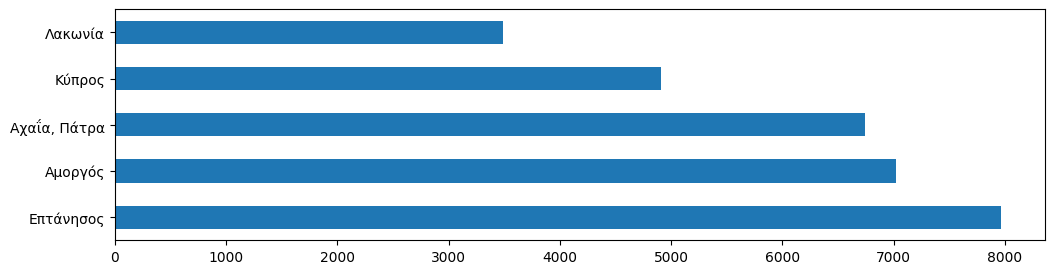

In [49]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

* Visualising the places along with the number of proverbs collected there

In [50]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html'); m

* Next, we work with ones that own 1,000 or more proverbs, allowing sampling without class imbalance issues

In [52]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


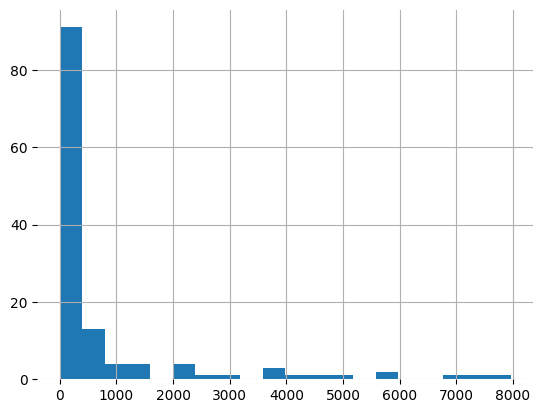

In [53]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000


In [54]:
common_places = placed_pd[placed_pd.length>1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


In [55]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* Creating a location-balanced corpus


In [56]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TF * IDF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across all places are more important (IDF). 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
X = vect.fit_transform(long_texts)

In [59]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [61]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζα,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.008863,...,0.000000,0.374153,0.000000,0.0,0.000000,0.000000,0.015568,0.006237,0.0,0.01701
ν τζ,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.007679,0.293327,0.000000,0.0,0.008527,0.000000,0.000000,0.006668,0.0,0.00000
τζι,0.0,0.0,0.0,0.0,0.0,0.0,0.022479,0.0,0.0,0.000000,...,0.000000,0.253328,0.007236,0.0,0.008527,0.009294,0.000000,0.000000,0.0,0.00000


* Computing a lexicon with the terms with the highest TFIDF value per area

In [62]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}

* Locating the important terms on the map

In [63]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [64]:
geotfidf.to_csv("geotfidf.csv")

# Authorship analysis
* Training one language model per area, by sampling proverbs of that area



In [74]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [88]:
# INFO: robustness at stake
#!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))
    
def ling_dist(proverb, models=models):
    entropy = {loc:[models[loc].cross_entropy(proverb)] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

,Κεφαλληνία,Ανατολική Θράκη,Λακωνία,Επτάνησος,Ρόδος,Κρήτη,Μικρά Ασία,Ιωάννινα,Θεσπρωτία,Αμοργός,...,Νάξος,Θράκη,Αρκαδία,Εύβοια,Μακεδονία,Σκύρος,Κύπρος,Αιτωλία,Λέσβος,Πόντος
0,3.024441,3.820882,3.933766,3.99251,4.090303,4.103385,4.143181,4.186436,4.249217,4.359568,...,4.655523,4.708621,4.730481,4.791411,4.794115,4.876166,4.998276,5.481236,5.73671,5.894881


* Evaluating on unseen proverbs

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.30      0.25      0.27        24
        Αμοργός       0.11      0.09      0.10        22
Ανατολική Θράκη       0.18      0.25      0.21        24
        Αρκαδία       0.15      0.13      0.14        31
          Αχαΐα       0.38      0.34      0.36        32
      Επτάνησος       0.28      0.30      0.29        23
         Εύβοια       0.07      0.10      0.08        20
      Θεσπρωτία       0.19      0.23      0.20        22
          Θράκη       0.15      0.12      0.13        25
       Ιωάννινα       0.19      0.14      0.16        29
       Κάρπαθος       0.48      0.36      0.41        28
     Κεφαλληνία       0.12      0.15      0.13        27
          Κρήτη       0.22      0.23      0.23        30
         Κύπρος       0.71      0.62      0.67        24
         Λέσβος       0.56      0.42      0.48        24
        Λακωνία       0.12    

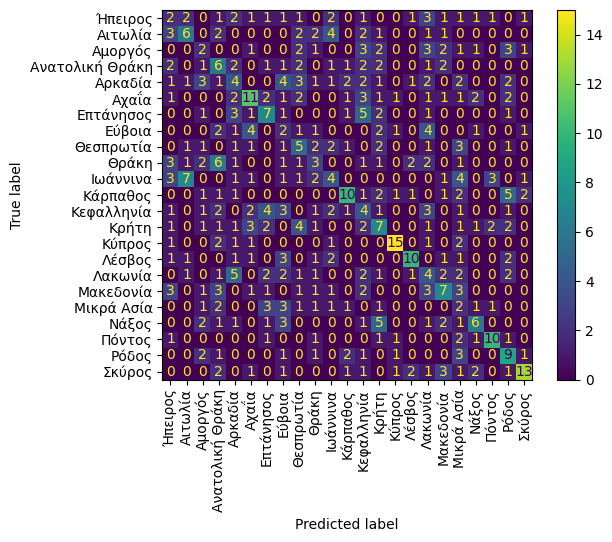

In [89]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
print(classification_report(test.area.values, predictions, zero_division=0))
ConfusionMatrixDisplay.from_predictions(test.area.values, predictions, xticks_rotation='vertical');

# Text spatial classification

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

Learning a location classifier on top of character n-grams

                 precision    recall  f1-score   support

        Ήπειρος       0.23      0.13      0.17        23
        Αιτωλία       0.18      0.33      0.24        24
        Αμοργός       0.17      0.18      0.17        22
Ανατολική Θράκη       0.14      0.12      0.13        24
        Αρκαδία       0.17      0.13      0.15        31
          Αχαΐα       0.44      0.34      0.39        32
      Επτάνησος       0.37      0.57      0.45        23
         Εύβοια       0.05      0.05      0.05        20
      Θεσπρωτία       0.13      0.14      0.13        22
          Θράκη       0.14      0.12      0.13        25
       Ιωάννινα       0.05      0.03      0.04        29
       Κάρπαθος       0.57      0.46      0.51        28
     Κεφαλληνία       0.33      0.37      0.35        27
          Κρήτη       0.21      0.17      0.19        30
         Κύπρος       0.67      0.75      0.71        24
         Λέσβος       0.39      0.46      0.42        24
        Λακωνία       0.12    

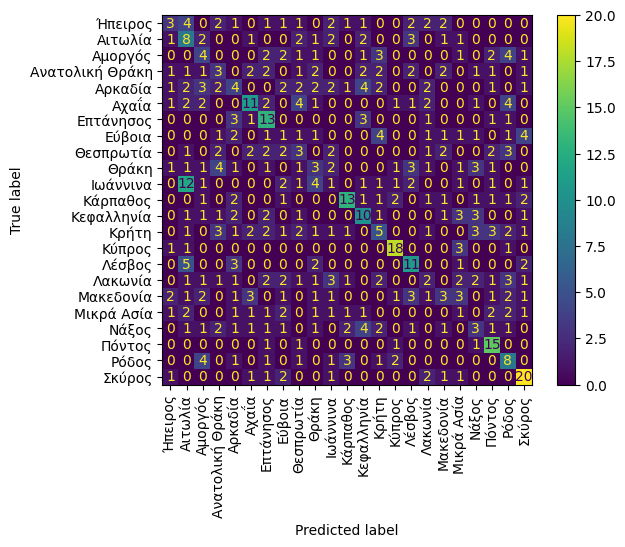

In [90]:
# text classification flat
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
locator = Pipeline([('vect', vect), ('clf', LogisticRegression())])
locator.fit(train.text.values, train.area.values)
txt_preds = locator.predict(test.text.values)
print(classification_report(test.area.values, txt_preds, zero_division=0))
ConfusionMatrixDisplay.from_estimator(locator, test.text.values, test.area.values, xticks_rotation='vertical');

# Classifying non-located proverbs

In [67]:
unseen_predictions = locator.predict(proverbs_sp_unk.text.values)
unseen_predictions_conf = locator.predict_proba(proverbs_sp_unk.text.values)
unseen_predicted_pd = pd.DataFrame({"text": proverbs_sp_unk.text, 
                                    "prediction": unseen_predictions, 
                                    "confidence": [max(x) for x in unseen_predictions_conf]})
unseen_predicted_pd.sort_values(by="confidence", ascending=False).head(10)

,text,prediction,confidence
117337,"Ανdάσ σου διούμ πκιάννε, τζ' ανdάθ θωρείς, μεν...",Κύπρος,0.747781
99688,Το λόγον ατ δύο κ' εφτεάει,Πόντος,0.680159
89938,"Αρμάστου αρμάστου, τσαί dεpοί τωρεί dυο μέραι ...",Σκύρος,0.602666
77232,Αυτός είναι Παύλος,Αχαΐα,0.599821
42157,"Έδωκαν πρόσωπον τον Αλήν, κ' εσκώθεν κ' εσ' εσ...",Πόντος,0.594672
97583,Αυτός είναι Ηρώδης,Αχαΐα,0.550544
119325,Αυτός είναι άμπακας,Αχαΐα,0.541991
103540,Αυτός είναι κλαψομάρτης,Αχαΐα,0.427492
82103,Ανάλατα λόγια,Λέσβος,0.389782
1902,Τα λόγια μ'σό γουdούκ' σε γιμίζουν,Λέσβος,0.339019


In [68]:
unseen_predicted_pd.to_excel("proverbs_located.xlsx", index=False)
unseen_predicted_pd[unseen_predicted_pd.confidence>0.5].shape

(7, 3)

# Classifying multi-located proverbs

In [91]:
duplicated_predicted_pd = duplicates[duplicates.area_num>1]
duplicated_predicted_pd.insert(4, "prediction", locator.predict(duplicated_predicted_pd.index.values))
probs = locator.predict_proba(duplicated_predicted_pd.index.values)
duplicated_predicted_pd.insert(5, "confidence", probs.max(1))
duplicated_predicted_pd.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicated_predicted_pd.sort_values(by="confidence", ascending=False).head(20)

,place,place_num,area,area_num,prediction,confidence,latlon
text,,,,,,,
Αυτός είναι ανεμόμυλος,"{Ανατολική Θράκη, Αχαΐα, Πάτρα, Μικρά Ασία, Κυ...",3,"{Ανατολική Θράκη, Αχαΐα, Μικρά Ασία}",3,Αχαΐα,0.539794,"[(41.6759327, 26.5587225), (38.0692748, 21.872..."
Πίσου είνι του πουτήρ' μι τ' ρίγαν',"{Αρκαδία, Γορτυνία, Λάστα, Αιτωλία, Αμβρακιά}",2,"{Αιτωλία, Αρκαδία}",2,Αιτωλία,0.501083,"[(37.4204248, 24.9479564), (38.0368583, 23.668..."
Αυτός είνι κατέβα να φάμι,"{Σάμος, Μαραθόκαμπος, Λέσβος, Πλωμάρι}",2,"{Σάμος, Λέσβος}",2,Αιτωλία,0.470703,"[(37.72461615, 26.819291891109838), (39.175841..."
Αυτός είναι μη μου άπτου,"{Ιωάννινα, Νεγάδες, Αμοργός}",2,"{Αμοργός, Ιωάννινα}",2,Αχαΐα,0.462285,"[(36.85252415, 25.898486967715655), (39.663981..."
Μ' πήρι τ' αυτιά,"{Ιωάννινα, Νεγάδες, Ήπειρος, Ζαγόρι}",2,"{Ήπειρος, Ιωάννινα}",2,Αιτωλία,0.440639,"[(37.9574332, 23.7108518), (39.6639818, 20.852..."
Αυτός είναι διάβολος με τα κέρατα,"{Μικρά Ασία, Κύζικος, Πάνορμος, Αχαΐα, Πάτρα}",2,"{Αχαΐα, Μικρά Ασία}",2,Αχαΐα,0.384379,"[(38.0692748, 21.87273042232539), (38.1846366,..."
Όπου γάιδαρος κι αυτός σαμάρι,"{Αρκαδία, Γορτυνία, Ιωάννινα}",2,"{Αρκαδία, Ιωάννινα}",2,Αιτωλία,0.357448,"[(38.0368583, 23.6689264), (39.6639818, 20.852..."
Γέρασι κι γνώσ' στου κιφάλ' τ' δεν έβαλε,"{Ιωάννινα, Νεγάδες, Ήπειρος, Ζαγόρι}",2,"{Ήπειρος, Ιωάννινα}",2,Αιτωλία,0.350946,"[(37.9574332, 23.7108518), (39.6639818, 20.852..."
Αυτνού τ' γιννάι κι' ου πέτνους,"{Ιωάννινα, Νεγάδες, Ήπειρος, Ζαγόρι}",2,"{Ήπειρος, Ιωάννινα}",2,Αιτωλία,0.342036,"[(37.9574332, 23.7108518), (39.6639818, 20.852..."


# Regression on the coordinates
* Instead of classifying the place, we can learn to predict the geographical coordinates.
* By using linear regression, we can measure feature importance afterwards, n-grams which distinguish spatially, from South to North, from West to East. 

In [92]:
# regression (lat/lon) - at the word level for efficiency
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

In [93]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 1.000
R2 (dev): -0.337


In [94]:
print(f"MAE lat/lon: {mean_absolute_error(test.lat.values, txt_preds[:, 0]):.2f} / {mean_absolute_error(test.lon.values, txt_preds[:, 1]):.2f}")

MAE lat/lon: 1.63 / 2.33


In [95]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

* n-grams pushing north (i.e., higher lat)


In [96]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
17604,κ,10.571103,7.135336
16071,ι η μ,10.507967,1.306656
20099,λός ο,10.357575,-3.208881
15521,ητο,9.867269,5.994671
32235,υν απ,9.153185,-5.177840


* n-grams pushing south (lower lat)


In [97]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
28789,σα μο,-12.405191,-8.281622
21745,ν!,-11.679777,-8.525111
6339,άριν,-9.802441,2.228184
18883,κότε,-9.477622,-2.612307
23190,ο έρ,-9.223007,4.089464


* n-grams pushing east (higher lon)


In [98]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
22945,νύφ',0.409734,13.940674
26718,ρέχο,-5.830237,13.362985
27392,ριος,-2.263486,12.873766
24181,ον πα,3.500749,12.697694
8745,α ο κ,-4.615436,12.643392


* n-grams pushing west (lower lon)


In [99]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
6098,άμουν,5.662567,-18.198989
23509,ο παρ,-0.836762,-16.315144
11364,βε,-7.313073,-15.722417
13069,ε κακ,-6.191143,-13.991529
15094,η τζ,3.500142,-12.854035


# Agglomerative clustering

* Besides duplicate proverbs, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* We employ linguistic distance to estimate the route of a proverb, assuming that shorter travels lead to fewer edits.   


```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Picking a proverb to act as our target


In [100]:
target = "Γιάννης κερνάει και Γιάννης πίνει"
proverbs[(proverbs.text.str.contains(target))]

,text,place,uri,collector,area,lat,lon
2226,Γιάννης κερνάει και Γιάννης πίνει,Φιλιππούπολη,http://hdl.handle.net/20.500.11853/177233,"Αποστολίδης, Μύρτιλος Κ.",Φιλιππούπολη,39.632764,22.396523
47375,Γιάννης κερνάει και Γιάννης πίνει!,"Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/212183,"Κορύλλος, Χρήστος Π.",Αχαΐα,38.069275,21.872730
72955,Γιάννης κερνάει και Γιάννης πίνει,"Θεσσαλία, Τρίκαλα",http://hdl.handle.net/20.500.11853/211888,"Μαλαβάκη, Ελένη",Θεσσαλία,39.559419,21.684849
97372,Γιάννης κερνάει και Γιάννης πίνει,"Αχαΐα, Καλάβρυτα",http://hdl.handle.net/20.500.11853/161564,"Παπανδρέου, Γεώργιος",Αχαΐα,38.069275,21.872730


* Fetching proverbs up to a given linguistic distance compared to our target.

In [ ]:
!pip install python-Levenshtein
from Levenshtein import distance as lev
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))

In [104]:
close_candidates = candidates[candidates.lev < 20]

* Hierarchically clustering the candidate versions of our target proverb
* Employing single linkage: the minimum possible distance between the proverbs of the two sets.




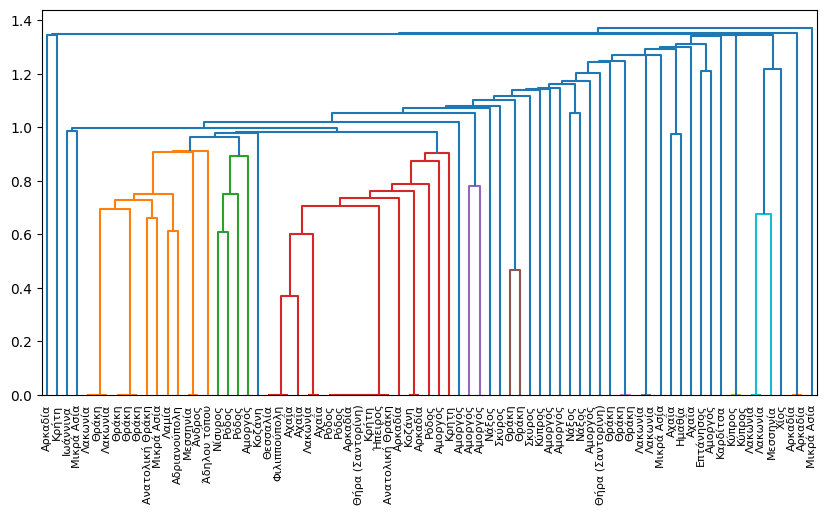

In [105]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(close_candidates.text.values)
#import sys; sys.setrecursionlimit(10000)
Z = linkage(X.toarray(), 'single')
plt.figure(figsize=(10, 5))
dendrogram(Z,
           orientation='top',
           labels=close_candidates.area.values,
           distance_sort='descending',
           show_leaf_counts=False,
           leaf_font_size=8.,
           show_contracted=True,
          )
plt.show();
clustering = fcluster(Z, t=1, criterion='distance')